In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/melboune-geojson/neighbourhoods.geojson
/kaggle/input/melbourne-airbnb-2021-Dec/calendar.csv
/kaggle/input/melbourne-airbnb-2021-Dec/listings.csv
/kaggle/input/melbourne-airbnb-2021-Dec/reviews.csv


### Libraries

In [2]:
import math
# to check NaN - https://stackoverflow.com/questions/944700/how-can-i-check-for-nan-values
import ast
# Literal evaluation of lists in string format - https://stackoverflow.com/questions/1894269/how-to-convert-string-representation-of-list-to-a-list
import matplotlib.pyplot as plt
import seaborn as sns

## Melbourne dataset
- Our dataset is sourced from [InsideAirbnb](http://insideairbnb.com/), where the data represents publicly available information from the Airbnb site for bookings in Melbourne
- We are using data which is scraped from 8th of December 2021

### Details of dataset
- `listings.csv` - Listing of available Aribnb bookings as at 8th of December 2021
- `reviews.csv` - All reviews (not only limited to 2021) for all listings
- `calendar.csv` - Availability of bookings from 8th December 2021 to 7th December 2021 for all listings
    - Each individual listing in `listings.csv` would have 365 rows of data in `calendar.csv`

### Data dictionary
- Data dictionary for all datasets above - [Link](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=0)

In [3]:
# Reading melbourne dataset
listings_melb = pd.read_csv('/kaggle/input/melbourne-airbnb-2021-Dec/listings.csv')
reviews_melb = pd.read_csv('/kaggle/input/melbourne-airbnb-2021-Dec/reviews.csv')
calendar_melb = pd.read_csv('/kaggle/input/melbourne-airbnb-2021-Dec/calendar.csv')

In [4]:
# Shape of datasets
print(f'Listings - {listings_melb.shape}')
print(f'Reviews  - {reviews_melb.shape}')
print(f'Calendar - {calendar_melb.shape}')

Listings - (17834, 74)
Reviews  - (466959, 6)
Calendar - (6509410, 7)


In [5]:
# Listings
listings_melb.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,20211207182258,2021-12-08,Beautiful Room & House,"<b>The space</b><br />House: Clean, New, Moder...",Very safe! Family oriented. Older age group.,https://a0.muscache.com/pictures/44620/5a5815c...,33057,https://www.airbnb.com/users/show/33057,...,4.75,4.50,4.67,NaN,f,1,0,1,0,0.03
1,12936,https://www.airbnb.com/rooms/12936,20211207182258,2021-12-08,St Kilda 1BR+BEACHSIDE+BALCONY+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,https://a0.muscache.com/pictures/59701/2e8cdaf...,50121,https://www.airbnb.com/users/show/50121,...,4.83,4.78,4.66,NaN,f,10,10,0,0,0.30


In [6]:
# Reviews
reviews_melb.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,9835,279854,2011-05-24,560832,Miriam,"Very hospitable, much appreciated.\r<br/>"
1,9835,3640746,2013-02-26,5143343,Michelle,A beautiful house in a lovely quiet neighbourh...


In [7]:
# Calendar
calendar_melb.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,438849,2021-12-08,f,$200.00,$200.00,10.0,1125.0
1,9835,2021-12-08,t,$60.00,$60.00,1.0,365.0


## Listing data
### Preliminary cleaning of data
#### Easy removal of columns
- From my first glance over `reviews_melb` and `calendar_melb`, there doesn't seem to be many column which immediately requires removal
- Inspection of `listings_melb` suggests that there are a number of columns which can be immediately removed, i.e.
    - `listing_url` - url of airbnb booking, since we already have this dataset which contains majority of information from the url links, we're unlikely to scrape this url anyway
    - `scrape_id` - all of the rows have the same scrape id since data has been scraped on the 8th of December 2021
    - `last_scraped`, `calendar_last_scraped` - only has 2 values, 7th and 8th of December, small difference in timing is unlikely to significantly impact analysis
    - `picture_url` - we're most likely not performing any analysis over listing images
    - `host_url`, `host_thumbnail_url`, `host_picture_url` - similar reason to remove as `listing_url` above
    - `neighbourhood_group_cleansed`, `calendar_updated`, `license`, `bathrooms` - no values for this column
    
- Unless we decide to conduct any sentiment analysis over text. we may consider removing the following columns
    - `name` - name of listing
    - `description` - detailed description of listing
    - `host_about` - introduction of listing hosts'
    
- Possible further feature engineering for these columns containing arrays, either to OneHot encode or to convert to number of unique values for each features below
    - `host_verifications`
    - `amenities`

In [8]:
listings_col_remove = ['listing_url', 'scrape_id', 'last_scraped', 'calendar_last_scraped', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'neighbourhood_group_cleansed', 'calendar_updated', 'license', 'bathrooms']
listings_melb_upt = listings_melb.drop(listings_col_remove, axis=1)

In [9]:
def schema_output(df):
    for col in df.columns:
        print(f'"{col}":', '{')
        print(f"\t\"title\": \"{col}\",")
        print(f"\t\"data_type\": {df[col].dtype}")
        print("}", end='')
        if df.columns[len(df.columns) - 1] != col:
            print(',', end='')
        print()

### Easy conversion of datatypes
- conversion to `datetime`
- conversion of `t/f` boolean to `True/False`
- conversion of numerical rates to float

In [10]:
LISTING_SCHEMA = {
    "host_since": {
        "title": "host_since",
        "data_type": 'date'
    },
    "host_response_rate": {
        "title": "host_response_rate",
        "data_type": 'rate'
    },
    "host_acceptance_rate": {
        "title": "host_acceptance_rate",
        "data_type": 'rate'
    },
    "host_is_superhost": {
        "title": "host_is_superhost",
        "data_type": bool
    },
    "host_has_profile_pic": {
        "title": "host_has_profile_pic",
        "data_type": bool
    },
    "host_identity_verified": {
        "title": "host_identity_verified",
        "data_type": bool
    },
    "has_availability": {
        "title": "has_availability",
        "data_type": bool
    },
    "first_review": {
        "title": "first_review",
        "data_type": 'date'
    },
    "last_review": {
        "title": "last_review",
        "data_type": 'date'
    },
    "instant_bookable": {
        "title": "instant_bookable",
        "data_type": bool
    }
}

In [11]:
def convert_rate(s):
    if type(s) == str:
        s = float(s.strip('%')) / 100
    return s

def prelim_conversion(df, schema):
    tmp = df.copy()
    for key, val in schema.items():
        if val['data_type'] == bool:
            tmp[key] = tmp[key].apply(lambda x : True if x == 't' else False)
        elif val['data_type'] == 'date':
            tmp[key] = pd.to_datetime(tmp[key])
        elif val['data_type'] == 'rate':
            tmp[key] = tmp[key].apply(convert_rate)
    return tmp

In [12]:
listings_melb_upt = prelim_conversion(listings_melb_upt, LISTING_SCHEMA)

### Specific data cleaning
- conversion of arrays to one hot encoded dummies - i.e. `host_verifications` and `amenities`
- conversion to numerical type - `price` and `bathrooms_text`

In [13]:
listings_melb_upt.head(2)

,id,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,9835,Beautiful Room & House,"<b>The space</b><br />House: Clean, New, Moder...",Very safe! Family oriented. Older age group.,33057,Manju,2009-08-21,AU,About us: We are an East Indian couple in our ...,NaN,...,5.00,4.75,4.50,4.67,False,1,0,1,0,0.03
1,12936,St Kilda 1BR+BEACHSIDE+BALCONY+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,50121,The A2C Team,2009-10-31,"Melbourne, Victoria, Australia",NaN,NaN,...,4.83,4.83,4.78,4.66,False,10,10,0,0,0.30


#### Cleaning `Price`

<AxesSubplot:>

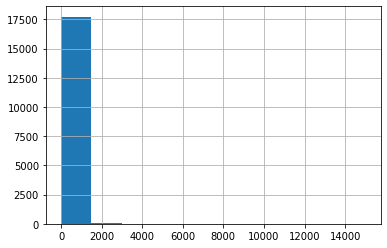

In [14]:
listings_melb_upt['price'].str.strip('$').str.replace(',', '').astype(float).hist()

#### Cleaning `bathrooms_text`
- Most of our data has either a bath, private bath, shared bath or half bath
- We feature engineer our data as follows:
    1. As shared bathrooms make up at least 20% of our dataset, we create another boolean column to represent whether it is a shared/non-shared bathroom
    2. To keep it simple, we will treat private as a normal bathroom (i.e. not-shared)
    3. Half baths do not have a numerical value, in such instances, we will just impute the value `0.5`

<AxesSubplot:>

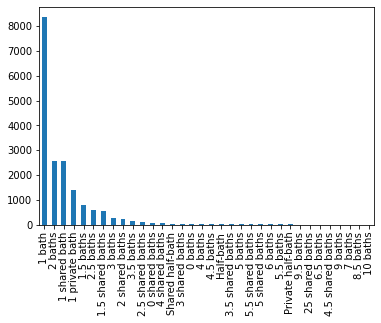

In [15]:
listings_melb_upt['bathrooms_text'].value_counts().plot.bar()

In [16]:
# Number of half baths
half_baths = listings_melb_upt['bathrooms_text'].str.contains(r'\b[Hh]alf\b').sum()
private_baths = listings_melb_upt['bathrooms_text'].str.contains(r'\b[Pp]rivate\b').sum()
print(f'Half baths - {half_baths}')
print(f'Private baths - {private_baths}')

Half baths - 50
Private baths - 1382


In [17]:
# Number of shared bathrooms
shared_baths = listings_melb_upt['bathrooms_text'].str.contains(r'\b[Ss]hared\b').sum()
print(f'No of shared bathrooms - {shared_baths}')
print(f'Proportion of shared bathrooms - {round(shared_baths / listings_melb_upt.shape[0], 4)}')

No of shared bathrooms - 3594
Proportion of shared bathrooms - 0.2015


<AxesSubplot:>

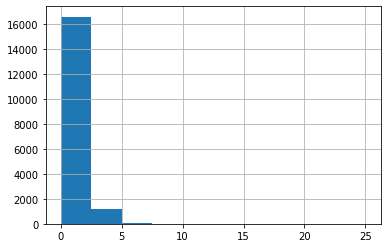

In [18]:
def fill_bathroom_num(s):
    # check not null
    if type(s) != str:
        return s
    elif 'Half' in s or 'half' in s:
        return 0.5
    else:
        return float(s.split()[0])
    
listings_melb_upt['bathrooms_text'].apply(fill_bathroom_num).hist()

In [19]:
# Shared bathrooms
listings_melb_upt['bathrooms_text'].str.contains(r'\b[Ss]hared\b').value_counts()

False    14209
True      3594
Name: bathrooms_text, dtype: int64

#### Cleaning `amenities` and `host_verifications`

In [20]:
def unique_vals(col):
    unique_values = set()
    for x in col:
        if type(x) == str and x != 'None':
            unique_values.update(ast.literal_eval(x))
    df = pd.DataFrame(0, index=col.index, columns=unique_values)
    for index, value in col.items():
        if type(value) == str and value != 'None':
            for item in ast.literal_eval(value):
                df.loc[index, item] = df.loc[index, item] + 1
    return df

In [21]:
amenities = unique_vals(listings_melb_upt['amenities'])

In [22]:
amenities.sum(axis=0).sort_values()[-20:]

Cooking basics               9166
Microwave                    9179
Refrigerator                 9472
Free parking on premises     9577
Dishes and silverware        9799
Hot water                   11465
Dedicated workspace         11630
TV                          12624
Shampoo                     13059
Hair dryer                  13418
Iron                        13649
Air conditioning            13787
Hangers                     14638
Heating                     15148
Long term stays allowed     15184
Washer                      15211
Wifi                        16139
Essentials                  16244
Smoke alarm                 16363
Kitchen                     16480
dtype: int64

In [23]:
verifications = unique_vals(listings_melb_upt['host_verifications'])

In [24]:
verifications.sum(axis=0).sort_values()

sent_id                      2
kba                         27
sesame                      32
sesame_offline              32
weibo                       94
manual_online              121
zhima_selfie               125
manual_offline             239
google                     784
facebook                  2914
work_email                3475
identity_manual           5568
selfie                    5792
offline_government_id     9125
reviews                  10199
jumio                    10542
government_id            12003
email                    16282
phone                    17750
dtype: int64

#### Collate data cleaning
- convert `price` and `bathrooms_text` to numerical form
- for array values above (`amenities` and `host_verifications`), let's have them stored as variables above and remove from our main dataframe for now

In [25]:
def clean_listng_data(df):
    tmp = df.copy()
    # Convert prices to numerical
    tmp['price'] = tmp['price'].str.strip('$').str.replace(',', '').astype(float)
    # Convert bathrooms text to numerical
    tmp['bathrooms'] = tmp['bathrooms_text'].apply(fill_bathroom_num)
    # apply new feature on whether bathroom is shared
    tmp['bathroom_is_shared'] = tmp['bathrooms_text'].str.contains(r'\b[Ss]hared\b').astype(bool)
    # drop bathrooms_text, and array columns
    tmp.drop(['bathrooms_text', 'amenities', 'host_verifications'], inplace=True, axis=1)
    return tmp

In [26]:
listings_melb_upt = clean_listng_data(listings_melb_upt)

### Reviews
- Let's perform a quick clean up by converting the `date` column to `datetime` format

In [27]:
reviews_melb_upt = reviews_melb.copy()
reviews_melb_upt['date'] = pd.to_datetime(reviews_melb_upt['date'])
reviews_melb_upt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466959 entries, 0 to 466958
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   listing_id     466959 non-null  int64         
 1   id             466959 non-null  int64         
 2   date           466959 non-null  datetime64[ns]
 3   reviewer_id    466959 non-null  int64         
 4   reviewer_name  466959 non-null  object        
 5   comments       466563 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 21.4+ MB


### Calendar
- We convert the following columns:
    - `date` - from object to datetime
    - `available` to boolean
    - `price` and `adjusted_price` to numerical

In [28]:
def clean_calendar_data(df):
    tmp = df.copy()
    tmp['date'] = pd.to_datetime(tmp['date'])
    tmp['available'] = tmp['available'].apply(lambda x : True if x == 't' else False)
    tmp['price'] = tmp['price'].str.strip('$').str.replace(',', '').astype(float)
    tmp['adjusted_price'] = tmp['adjusted_price'].str.strip('$').str.replace(',', '').astype(float)
    return tmp

In [29]:
calendar_melb_upt = clean_calendar_data(calendar_melb)
calendar_melb_upt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6509410 entries, 0 to 6509409
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       bool          
 3   price           float64       
 4   adjusted_price  float64       
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1)
memory usage: 304.2 MB


## Reducing dataframe sizes

In [30]:
def calc_df_size(*args):
    tot_size = 0
    for df in args:
        tot_size += df.memory_usage().sum()
    return tot_size/1000000

In [31]:
size = calc_df_size(listings_melb_upt, reviews_melb_upt, calendar_melb_upt)
print(f'Initial size of dataset is {size} MB')

Initial size of dataset is 349.32947 MB


In [32]:
def reduce_df_size(df):
    num_col = df.select_dtypes(include=['int','float'])
    for col in num_col:
        max_ = df[col].max()
        min_ = df[col].min()
        if df[col].dtype == float:
#             if max_ <= np.finfo('float16').max and min_ >= np.finfo('float16').min:
#                 df[col] = df[col].astype(np.float16)
            if max_ <= np.finfo('float32').max and min_ >= np.finfo('float32').min:
                df[col] = df[col].astype(np.float32)
            # leave float64 as is
        elif df[col].dtype == int:
            if max_ <= np.iinfo('int8').max and min_ >= np.iinfo('int8').min:
                df[col] = df[col].astype(np.int8)
            elif max_ <= np.iinfo('int16').max and min_ >= np.iinfo('int16').min:
                df[col] = df[col].astype(np.int16)
            elif max_ <= np.iinfo('int32').max and min_ >= np.iinfo('int32').min:
                df[col] = df[col].astype(np.int32)
            # leave int64 as is
    return df

In [33]:
listings_melb_upt = reduce_df_size(listings_melb_upt)
reviews_melb_upt = reduce_df_size(reviews_melb_upt)
calendar_melb_upt = reduce_df_size(calendar_melb_upt)

size_upt = calc_df_size(listings_melb_upt, reviews_melb_upt, calendar_melb_upt)
print(f'Before: {size}, After: {size_upt}')
print(f'Decrease in size = {round((size - size_upt) / size * 100, 2)}%')

Before: 349.32947, After: 211.8923
Decrease in size = 39.34%


## Business understanding

### Stakeholders of Airbnb
- Guests - customers of airbnb who utilise the service
- Hosts - individuals offering their homes/accomodation for stay/rental
- Communities - Communities of which Airbnb stays exist
- Shareholders - 'Owners' of Airbnb
- Executives & Employees - Internal Airbnb staff

As our dataset relates to data scraped from Airbnb's publicly available bookings in Melbourne, it seems that the dataset is more externally geared towards `Guests` and `Hosts`. Although we could make a point that the information may be beneficial for Airbnb's `Executives & Employees`, extracting information from the dataset is likely to yield lower benefits for them considering that they would have more comprehensive internal information with regards to bookings.

- [Reference](https://news.airbnb.com/serving-all-stakeholders/#:~:text=The%20stakeholders%20who%20make%20up,Communities%2C%20Shareholders%2C%20and%20Employees.)

### Questions 
We narrow down our stakeholders to `Guests` and `Hosts` to derive the following high level questions

#### Guests
- How would I know if I am paying a fair price for a stay?
- How do hosts's listings in Airbnb influence my initial decision over appropriateness of price paid?

#### Hosts
- What factors influences the price of my stay? (`$`)
- What influences higher percentage of bookings throughout the year? (`$`)
- What drives customer satisfaction? (ratings)
- How can I improve my Airbnb listing to yield more customers? (`$`)

## Data Understanding
Let's perform further inspection of our data after preliminary cleaning above

### Missing data

In [34]:
import missingno as msno
%matplotlib inline

def missing_bar(df):
    # axis = 0 represents summing up column wise
    missing = df.isna().sum(axis=0)
    plt.title('Missing data for each column')
    plt.xlabel('Missing data')
    plt.ylabel('Column name')
    plt.barh(df.columns, missing)
    plt.xticks(rotation=90)
    plt.show()
    
def rows_with_missing(df):
    # sum axis 1 instead to represent row
    missing_bool = df.isna().sum(axis=1) > 0
    return df[missing_bool]

#### Listings

We observe that there are 27 missing features, which is about 44% of our data

In [35]:
# Number of missing columns for Listings dataframe
listings_missing = rows_with_missing(listings_melb_upt)
missing_features = (listings_missing.isna().sum(axis=0) != 0.0)
print(f'Total missing features - {missing_features.sum()}')
print(f'Proportion of missing features - {round(missing_features.sum() / missing_features.shape[0] * 100, 2) }%')

Total missing features - 27
Proportion of missing features - 44.26%


Number of missing rows are pretty significant at 88%

In [36]:
# Number of rows of listings dataset 
listings_missing = rows_with_missing(listings_melb_upt)

print(f'Number of missing rows in dataset - {listings_missing.shape[0]}')
print(f'Proportion of missing rows - {round(listings_missing.shape[0] / listings_melb_upt.shape[0] * 100, 2)}%')

Number of missing rows in dataset - 15793
Proportion of missing rows - 88.56%


- We can attempt to pinpoint whether rows with missing data clump together
- Based on the breakdown of missing values below, we can see that `host_response_time` and `host_response_rate` has the highest amount of missing values at 51%. Subsequently columns relating to `reviews`, hover around 23.5% to 25% of missing values
- Further inspection of feature datatypes suggest that there are a few `object` datatypes (i.e. strings)
    - Our strategy moving forward would be to ignore these types first unless we're performing further Sentiment analysis or keyword bucketing
    - Hence, missing values for these columns are unlikely to impact our main analysis for now

#### Key features (int or float dtype)
- host_response_time
- host_response_rate
- host_acceptance_rate
- review_scores_value            
- review_scores_location         
- review_scores_checkin          
- review_scores_accuracy         
- review_scores_communication    
- review_scores_cleanliness      
- last_review                    
- first_review                   
- reviews_per_month              
- review_scores_rating           

#### Not so important (`object` dtype)
- host_neighbourhood
- host_about
- neighborhood_overview
- neighbourhood

In [37]:
# Proportion of missing data for first 20 missing columns
listings_missing = listings_melb_upt.isna().sum(axis=0).sort_values(ascending=False)[:27] / listings_melb_upt.shape[0]
listings_missing

host_response_time             0.512056
host_response_rate             0.512056
host_neighbourhood             0.481832
host_acceptance_rate           0.472973
host_about                     0.423741
neighborhood_overview          0.377818
neighbourhood                  0.377706
review_scores_value            0.257374
review_scores_location         0.257374
review_scores_checkin          0.257374
review_scores_accuracy         0.257149
review_scores_communication    0.257037
review_scores_cleanliness      0.256981
last_review                    0.236234
first_review                   0.236234
reviews_per_month              0.236234
review_scores_rating           0.236234
bedrooms                       0.045867
beds                           0.041382
description                    0.037008
bathrooms                      0.001738
host_location                  0.001121
host_listings_count            0.000280
host_since                     0.000280
host_name                      0.000280


#### Listings Heatmap analysis
We observe 4 clumps of missing data which have high correlation with each other. We also observe the amount of missing data for each clump based on our analysis of proportion of missing data above:
- **Host response** - 51.2%
- **Host acceptance rate** - 47.3%
- **Reviews** - 23.6% to 25.7%
- **Host since/location** - 0.03%

Since `Host since/location`'s missing data is very minimal relative to others, it is safe to ignore this clump of missing features.

For the other clumps however, we would need to take these into careful consideration during our analysis later

<AxesSubplot:>

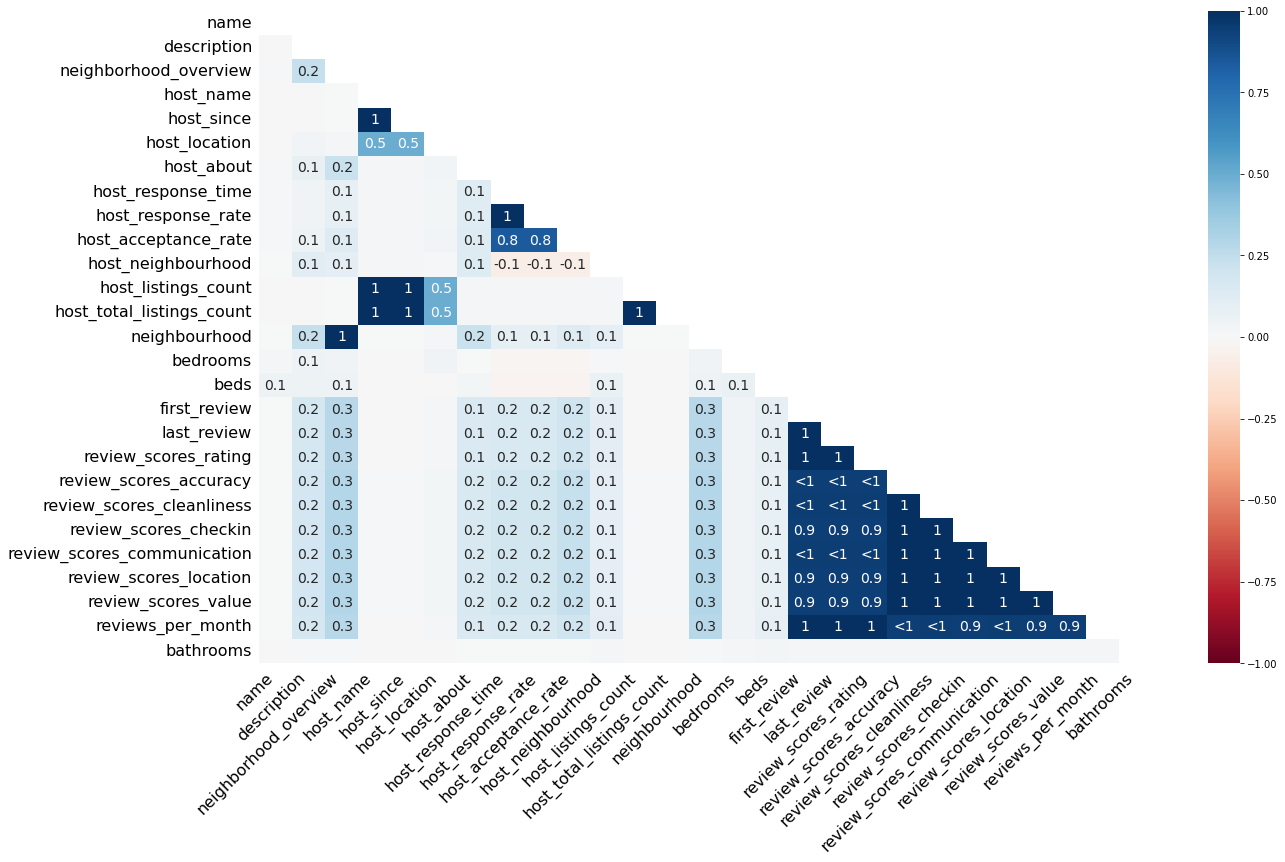

In [38]:
msno.heatmap(listings_melb_upt)

#### Reviews
- There is just 1 feature with missing data, i.e. `comment`
- Proportion of missing values are still pretty minimal, < 0.08%
- Unless we're performing some sentimental analysis or word aggregation over the comments, missing values for `Reviews` is unlikely to impact our analysis much

In [39]:
# Number of missing columns for Reviews dataframe
(reviews_melb_upt.isna().sum(axis=0) != 0.0).sum()

1

In [40]:
# Number of rows of reviews dataset 
reviews_missing = rows_with_missing(reviews_melb_upt)

print(f'Number of missing rows in dataset - {reviews_missing.shape[0]}')
print(f'Proportion of missing rows - {round(reviews_missing.shape[0] / reviews_melb_upt.shape[0] * 100, 2)}%')
reviews_missing.head(5)

Number of missing rows in dataset - 396
Proportion of missing rows - 0.08%


,listing_id,id,date,reviewer_id,reviewer_name,comments
2395,120487,128829335,2017-01-27,72638053,Aiman,NaN
6559,405515,4623670,2013-05-16,5516808,Jeff,NaN
8855,762695,276158344,2018-06-13,124659128,Dallas,NaN
19432,1732959,482729400,2019-07-07,273283853,Manju,NaN
22737,1950793,513689294,2019-08-20,275000905,Hugh,NaN


#### Calendar
- There is just 1 feature with missing data, i.e. `comment`
- Proportion of missing values is very minimal, < 0.01%
- Hence missing values for `Calendar` is unlikely to impact our analysis much

In [41]:
# Number of missing columns for Calendar dataframe
(calendar_melb_upt.isna().sum(axis=0) != 0.0).sum()

4

In [42]:
# Number of rows of calendar dataset 
calendar_missing = rows_with_missing(calendar_melb_upt)

print(f'Number of missing rows in dataset - {calendar_missing.shape[0]}')
print(f'Proportion of missing rows - {round(calendar_missing.shape[0] / calendar_melb_upt.shape[0] * 100, 2)}%')
calendar_missing.head(5)

Number of missing rows in dataset - 572
Proportion of missing rows - 0.01%


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
1018825,11382423,2021-12-07,False,300.0,300.0,NaN,NaN
1055997,11443550,2021-12-07,False,83.0,83.0,NaN,NaN
1877409,19664375,2021-12-08,False,NaN,NaN,7.0,1125.0
1877583,19664375,2021-12-09,False,NaN,NaN,7.0,1125.0
1877584,19664375,2021-12-10,False,NaN,NaN,7.0,1125.0


### Numerical data distribution

In [43]:
'''
By default, exclude object, datetime, timedelta and bool types and only consider numerical columns
'''
def plot_distribution(df, filter_col=None, bins=10):
    if filter_col == None:
        filter_col = df.select_dtypes(exclude=['object', 'datetime', 'timedelta', 'bool']).columns
    num_cols = len(list(filter_col))
    width = 3
    height = num_cols // width if num_cols % width == 0 else num_cols // width + 1
    plt.figure(figsize=(18, height * 3))
    for i, col in zip(range(num_cols), filter_col):
        plt.subplot(height, width, i + 1)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.hist(df[col], bins)
    plt.tight_layout()
    plt.show()

- An analysis of distribution of numerical data below suggest that majority of them are extremely skewed, save for `latitude` and `longitude`.
- It's impossible to gather any insights based on these distributions alone since all columns seem to have alot of outliers

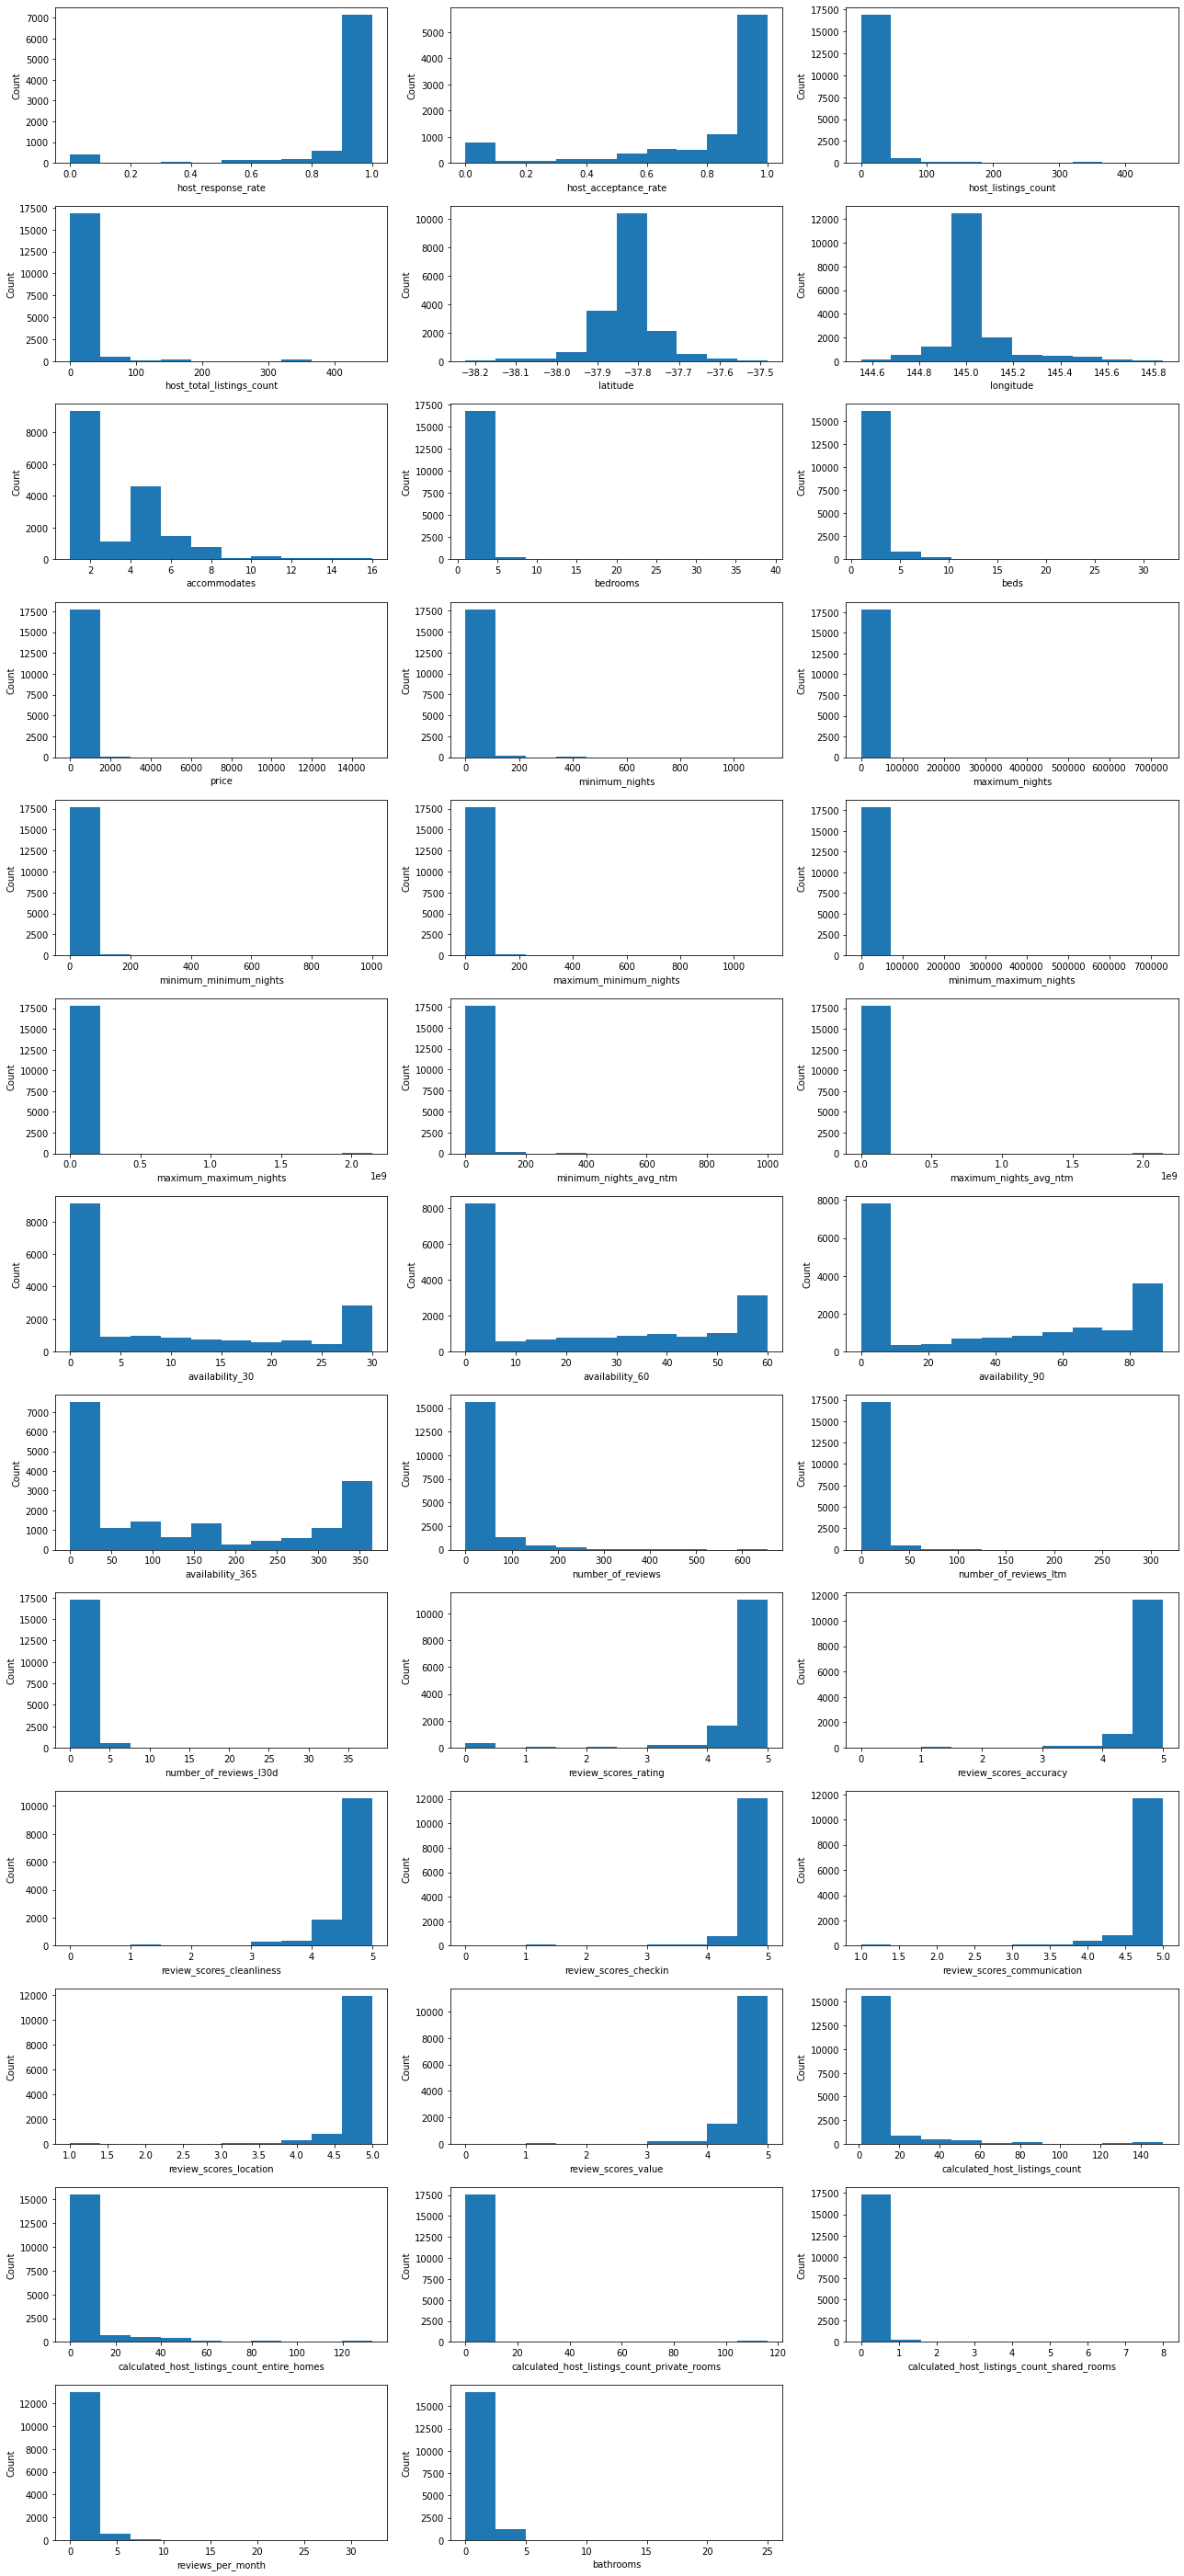

In [44]:
# Listings
plot_distribution(listings_melb_upt.drop(['id', 'host_id'], axis=1))

### Numerical Outliers

In [45]:
# iqr method
# https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097
def is_outlier(col, factor=1.5):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    iqr_factor = iqr * factor
    lower = q1 - iqr_factor
    higher = q3 + iqr_factor
    return (col < lower) | (col > higher)

In [46]:
numerical_cols = listings_melb_upt.select_dtypes(exclude=['object', 'datetime', 'timedelta', 'bool']).columns
numerical_cols

Index(['id', 'host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'r

Removing outliers of a factor of 4 of its interquartile range still only slightly improves the spread of data
- It may not be wise to outrightly remove these values given that almost 50% of ur data is removed

In [47]:
outlier = pd.Series(index=listings_melb_upt.index, data=False)
for col in numerical_cols:
    outlier = (outlier) | (is_outlier(listings_melb_upt[col], factor=4))
outlier.value_counts() / listings_melb_upt.shape[0]

True     0.540541
False    0.459459
dtype: float64

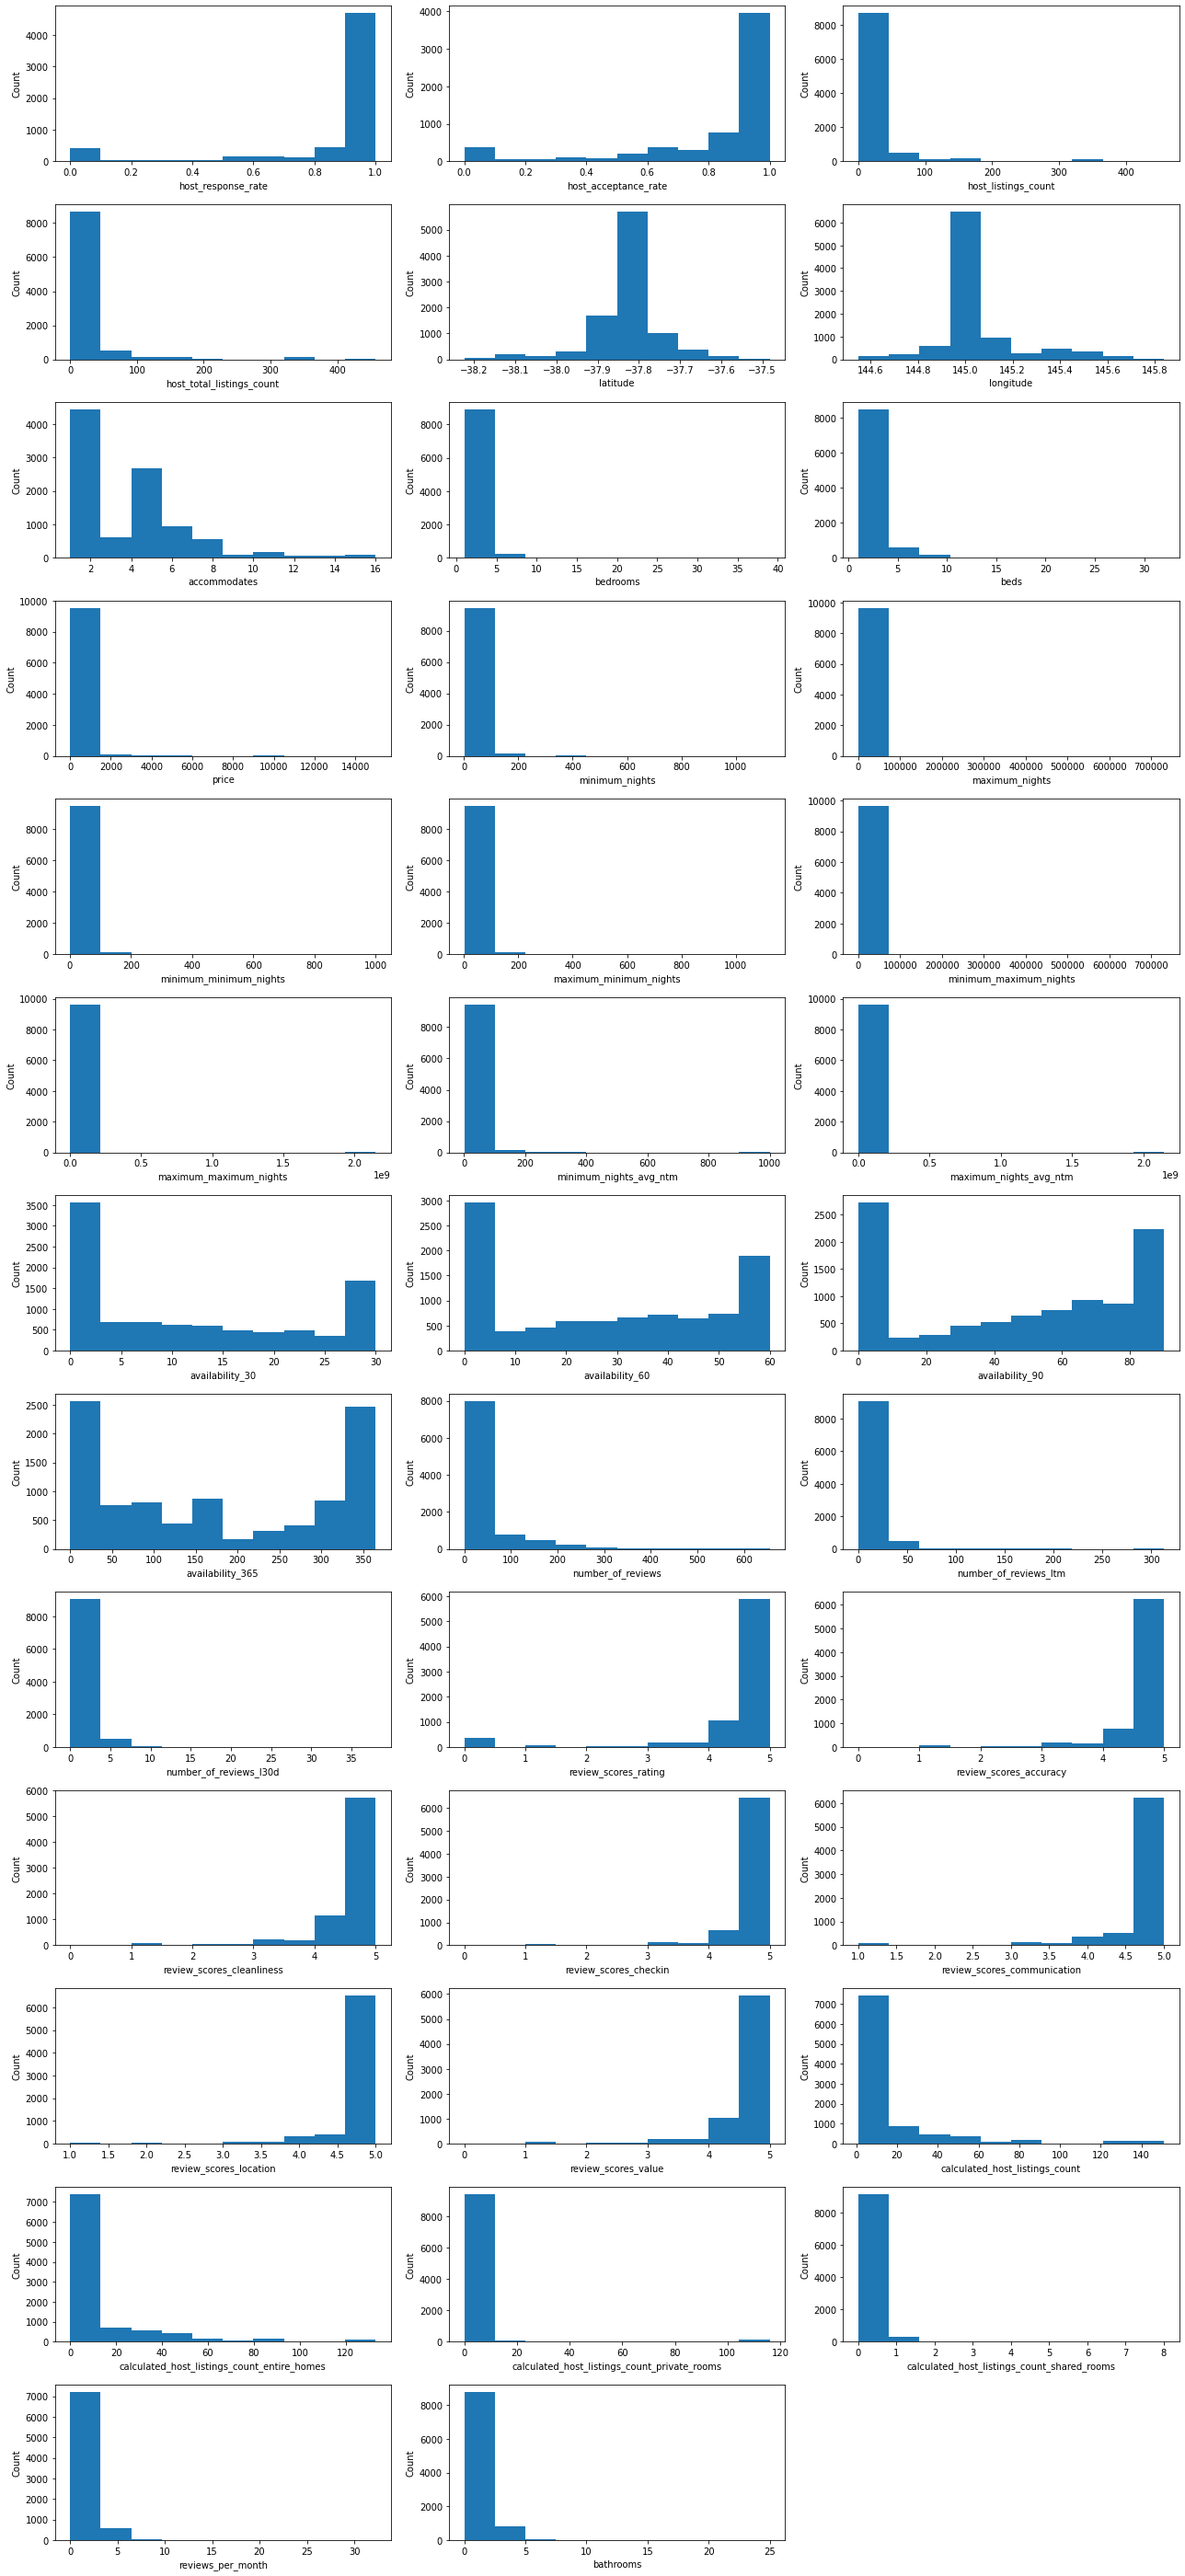

In [48]:
# Listings
plot_distribution(listings_melb_upt[outlier].drop(['id', 'host_id'], axis=1))

### Correlation
- We notice there are many columns in our dataset which share similar naming, e.g.
    - `minimum_nights`, and `minimum_minimum_nights`, etc
    - `availability_30`, `availability_60`, etc
    - `review_scores_value`, `review_scores_rating`, etc
- We analyze the correlations between each item below to consider removal of features
    - We should always try to reduce number of highly correlated features when training our model. The added number of features are unlikely to improve our model performance, and sometimes the added complexity may even make our models perform worse 

#### Min max nights
- These featurs describe the minimum and maximum number of nights a single booking needs to be
- The main features are `minimum_nights` and `maximum_nights`, and these are primarily set by the host
- Variation of these features are calculated during the scraping process where the bot analyzes the actual `min` and `max` days based on the calendar in the AirBnb booking.
- Below, as expected, the main features is highly correlated to the scrapped values, e.g. `minimum_nights` is highly correlated to `minimum_minimum_nights` and `maximum_minimum_nights`
    - Since there is pretty high correlation for min nights, i.e. 0.91 and 0.97, it is safe to just utilise `minimum_nights` as our only feature
    - For max nights however, we can utilise `maximum_nights` too
- There are 2 columns which do not have any correlation with `minimum_nights` and `maximum_nights`, i.e. `maximum_maximum_nights` and `maximum_nights_avg_ntm`. Since they are computed during scraping, I will remove them for now given that the information isn't directly available to users/customers.

<AxesSubplot:>

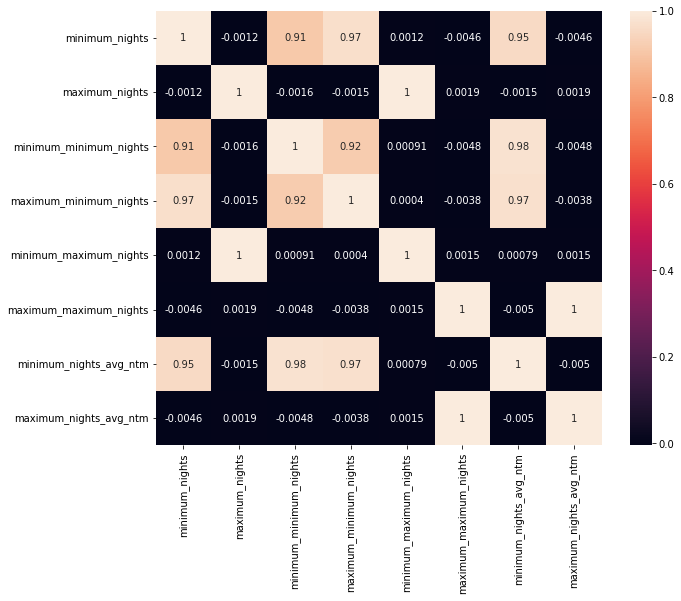

In [49]:
# Min max nights
min_max_nights = ['minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
plt.figure(figsize=(10,8))
sns.heatmap(listings_melb_upt[min_max_nights].corr(), annot=True)

#### Availability Days
- I will remove `availability_60` and `availability_90` since it has high correlation with `availability_30`

<AxesSubplot:>

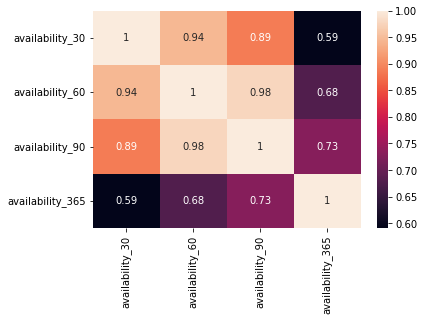

In [50]:
# Availability days
availability_cols = ['availability_30', 'availability_60','availability_90','availability_365']
sns.heatmap(listings_melb_upt[availability_cols].corr(), annot=True)

#### Reviews
There seems to be decent correlation between review scores, with no single pair showing extremely high correlation. Will remain these features as is

<AxesSubplot:>

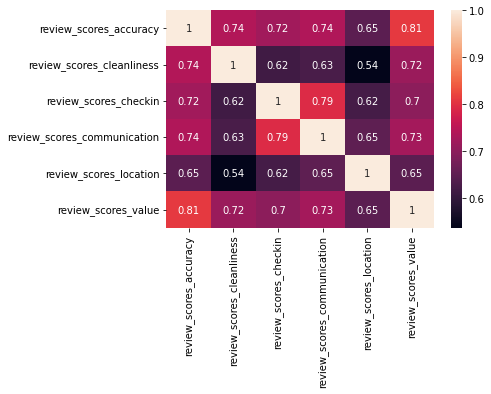

In [51]:
# Reviews
availability_cols = ['review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
sns.heatmap(listings_melb_upt[availability_cols].corr(), annot=True)

#### Host listings
There seems to be decent correlation between host listing information, with no single pair showing extremely high correlation (except for the `0.87` below). So, will remain these features as is.

<AxesSubplot:>

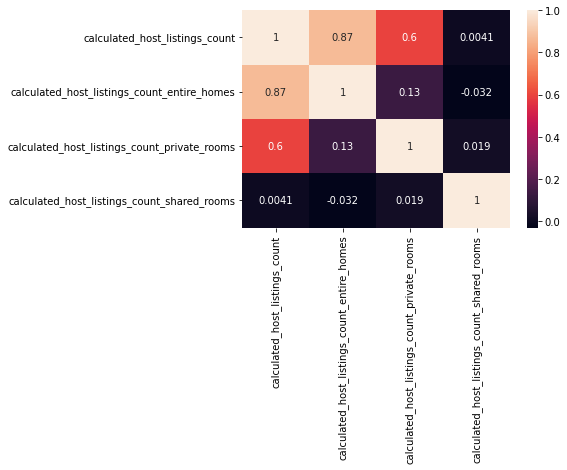

In [52]:
# Host listings
host_listings = ['calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', \
                     'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
sns.heatmap(listings_melb_upt[host_listings].corr(), annot=True)

## Data Understanding (cont'd)
Let's perform further inspection of our data after preliminary cleaning above

#### What is the average price of Melbourne AirBnbs?
- In total
- With regards to district

In [53]:
average_price = listings_melb_upt['price'].mean()
print(f'Average price as of 8th Dec 2021 = ${round(average_price, 2)}')

Average price as of 8th Dec 2021 = $182.76


In [54]:
# Excluding outliers
average_price = listings_melb_upt.loc[~is_outlier(listings_melb_upt['price']) , 'price'].mean()
print(f'Average price as of 8th Dec 2021 = ${round(average_price, 2)}')

Average price as of 8th Dec 2021 = $127.96


In [55]:
# We exclude outliers from plotting our data below
is_outlier(listings_melb_upt['price']).value_counts()

False    16523
True      1311
Name: price, dtype: int64

In [56]:
# boolean index for listings with 1 review or less
review_morethan_1 = listings_melb_upt['number_of_reviews'] > 10

In [57]:
# Average district prices
# using aggregate https://stackoverflow.com/questions/41040132/pandas-groupby-count-and-mean-combined
district_price = listings_melb_upt[(~is_outlier(listings_melb_upt['price']))].groupby('neighbourhood_cleansed') \
       .agg({'id':'size', 'price':'mean'}) \
       .rename(columns={'id':'count'}) \
       .reset_index()

In [58]:
# Top 5 most expensive
district_price.sort_values(by='price', ascending=False)[:5]

,neighbourhood_cleansed,count,price
29,Yarra Ranges,630,214.233337
22,Nillumbik,71,167.549301
4,Cardinia,135,163.940735
1,Bayside,233,159.133041
10,Hobsons Bay,195,148.841019


In [59]:
# Top 5 cheapest
district_price.sort_values(by='price')[:5]

,neighbourhood_cleansed,count,price
26,Whittlesea,137,83.051094
3,Brimbank,131,92.854965
0,Banyule,185,94.918922
21,Moreland,712,98.071632
6,Darebin,508,101.992126


In [60]:
# https://www.kaggle.com/imdevskp/geopandas
import geopandas as gpd
from shapely.geometry import Point, LineString

import folium
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [61]:
# Load geojson data
wc = gpd.read_file('/kaggle/input/melboune-geojson/neighbourhoods.geojson')
wc.index = wc['neighbourhood']
wc.head(2)

,neighbourhood,neighbourhood_group,geometry
neighbourhood,,,
Greater Dandenong,Greater Dandenong,None,"MULTIPOLYGON (((145.14170 -37.93139, 145.14255..."
Wyndham,Wyndham,None,"MULTIPOLYGON (((144.82749 -37.82280, 144.82654..."


[]

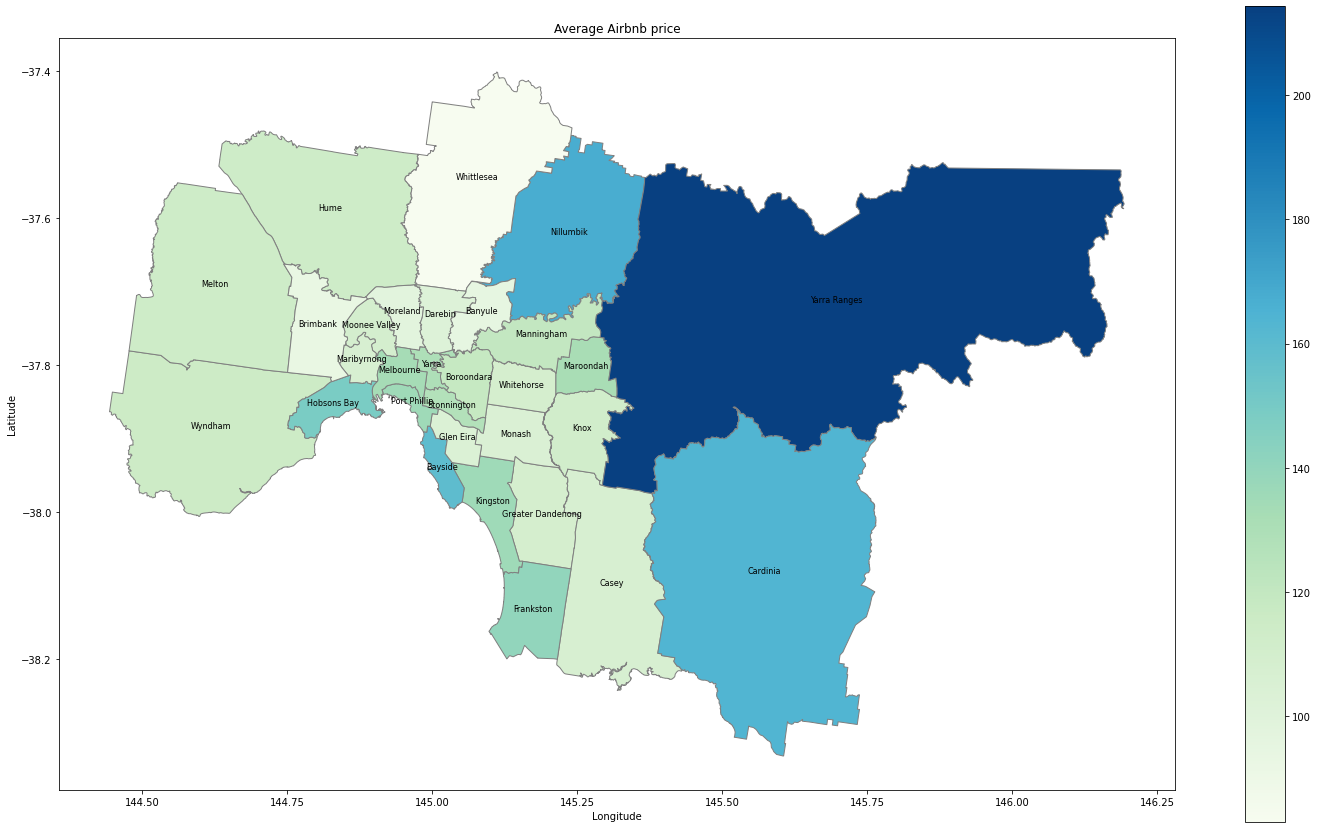

In [62]:
# Average price 
mean_price_series = pd.Series(data=district_price['price'])
mean_price_series.index=district_price['neighbourhood_cleansed']
wc['mean_price'] = mean_price_series
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
ax = wc.plot(figsize=(25,15), column='mean_price', cmap='GnBu', legend=True, edgecolor='gray')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Average Airbnb price')
# font size - https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
wc.apply(lambda x: ax.annotate(text=x['neighbourhood'], xy=x.geometry.centroid.coords[0], ha='center', font={'size':8}), axis=1)
ax.plot()

#### Where are Airbnbs concentrated in Melbourne?
- We observe that a significnat majority of Airbnbs belong in the Melbourne Central Business District (CBD)

In [63]:
# Top 5 most listings
district_price.sort_values(by='count', ascending=False)[:5]

,neighbourhood_cleansed,count,price
17,Melbourne,5006,132.892136
23,Port Phillip,1934,135.562042
28,Yarra,1291,129.364059
24,Stonnington,1129,127.204605
21,Moreland,712,98.071632


In [64]:
# Top 5 most listings
district_price.sort_values(by='count', ascending=True)[:5]

,neighbourhood_cleansed,count,price
22,Nillumbik,71,167.549301
16,Maroondah,80,132.175003
18,Melton,89,114.224716
9,Greater Dandenong,127,109.062996
3,Brimbank,131,92.854965


In [65]:
# Proportion of Melbourne CBD
district_price.loc[17, 'count'] / district_price['count'].sum()

0.30297161532409367

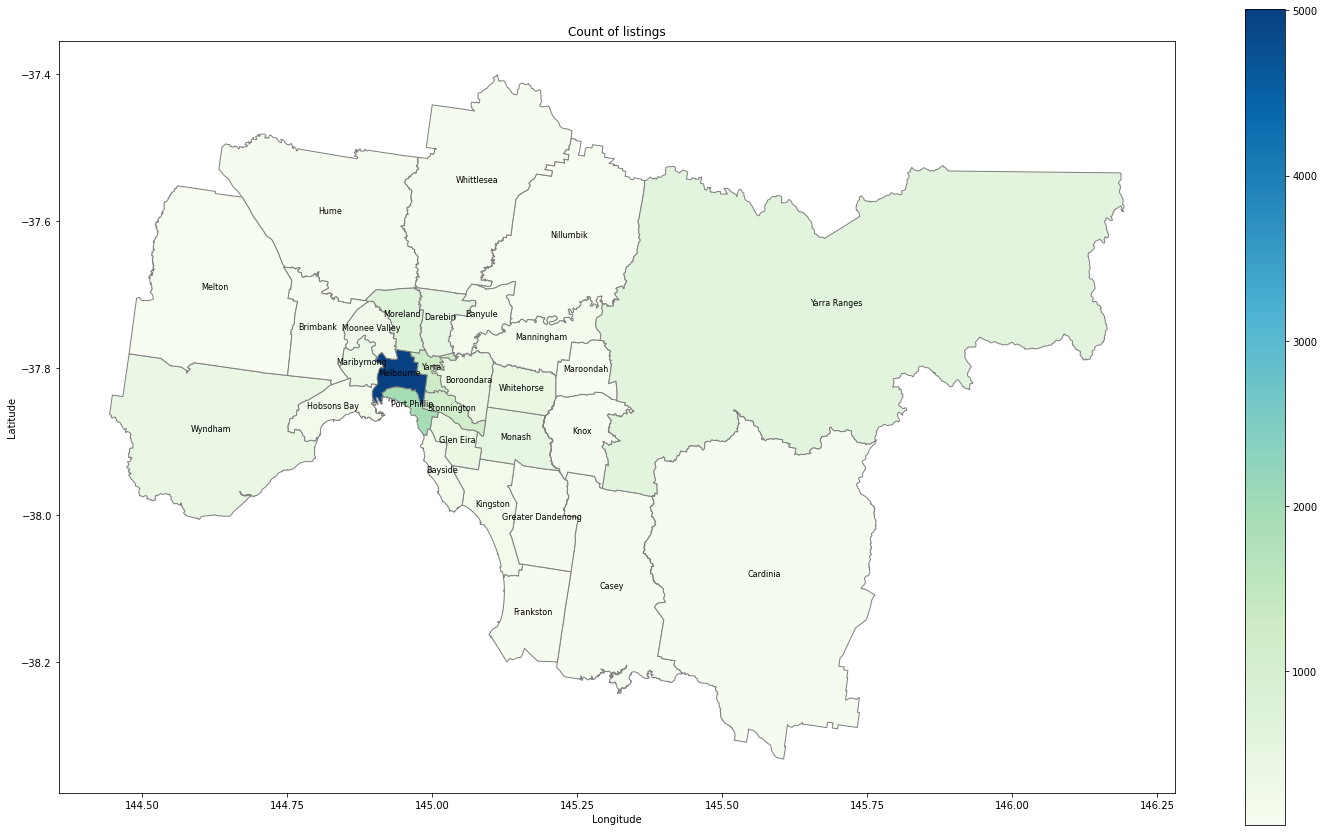

In [66]:
# Count of listing 
count_listing_series = pd.Series(data=district_price['count'])
count_listing_series.index=district_price['neighbourhood_cleansed']
wc['count_listing'] = count_listing_series
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
ax = wc.plot(figsize=(25,15), column='count_listing', cmap='GnBu', legend=True, edgecolor='gray')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Count of listings')
# font size - https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
wc.apply(lambda x: ax.annotate(text=x['neighbourhood'], xy=x.geometry.centroid.coords[0], ha='center', font={'size':8}), axis=1);

The scatterplot below shows a better representation of our spread of listings. Listings are concentrated in Melbourne CBD, and eventually disperse when going out of CBD. It may not be easily observable since there is a very disproportionate amount of listings in Melbourne itself compared to other districts.

Also, we observe a few clumps of listings in:
- Wyndham
- along the coast of Mayside, Kingston and Frankston
- Yarra Ranges for individuals who are interested in visiting the Yarra National Park and Vineyard

<AxesSubplot:title={'center':'Distribution of Airbnb listings'}, xlabel='longitude', ylabel='latitude'>

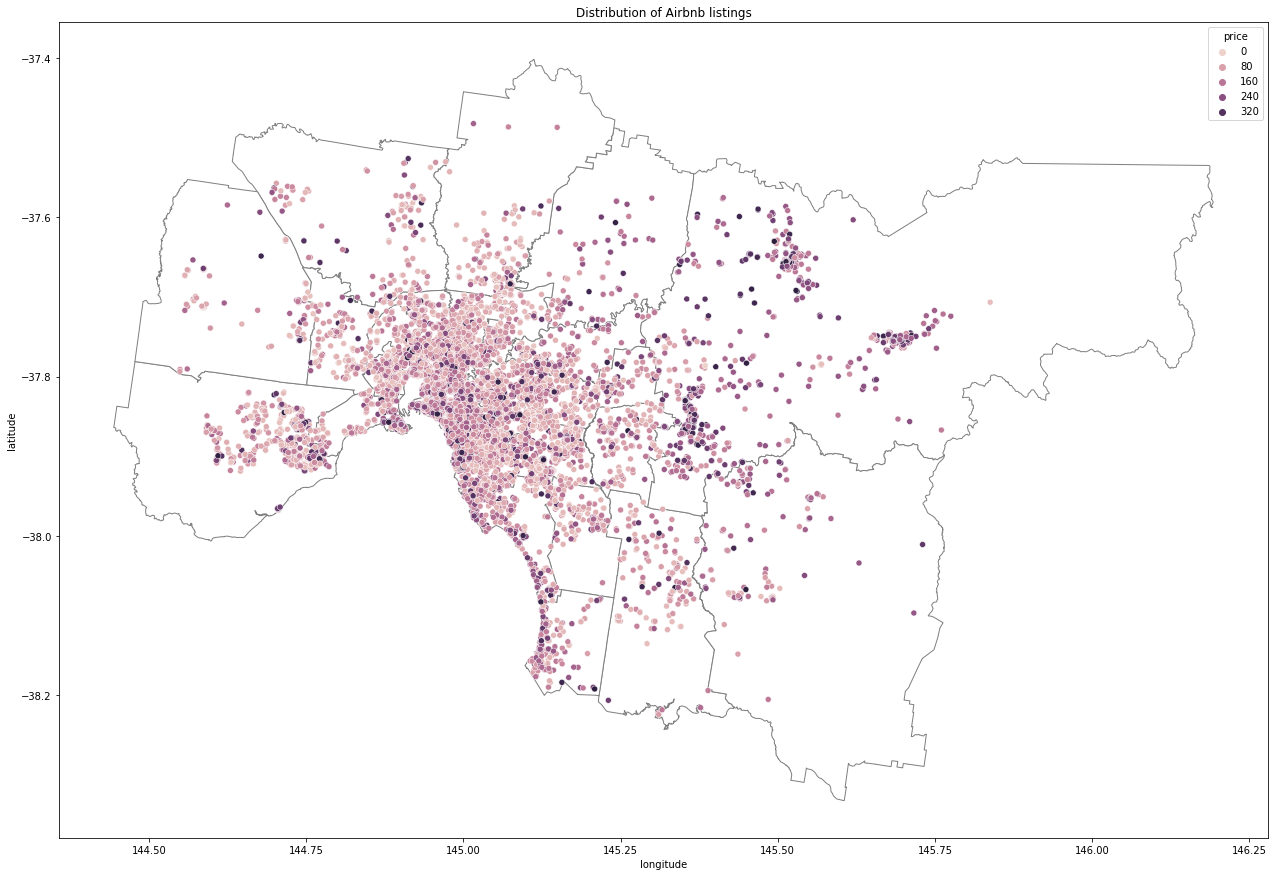

In [67]:
# graph looks terrible, need to remove outliers
# https://www.kaggle.com/imdevskp/geopandas

# does not include mornington peninsula
ax = wc.plot(figsize=(25,15), color='white', edgecolor='gray')
ax.set_title('Distribution of Airbnb listings')
sns.scatterplot(data=listings_melb_upt[~is_outlier(listings_melb_upt['price'])], x='longitude', y='latitude', hue='price')

#### Melbourne CBD

In [68]:
wc_melb = wc.filter(['Melbourne'], axis=0)
wc_melb

,neighbourhood,neighbourhood_group,geometry,mean_price,count_listing
neighbourhood,,,,,
Melbourne,Melbourne,None,"MULTIPOLYGON (((144.93708 -37.77779, 144.93734...",132.892136,5006


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

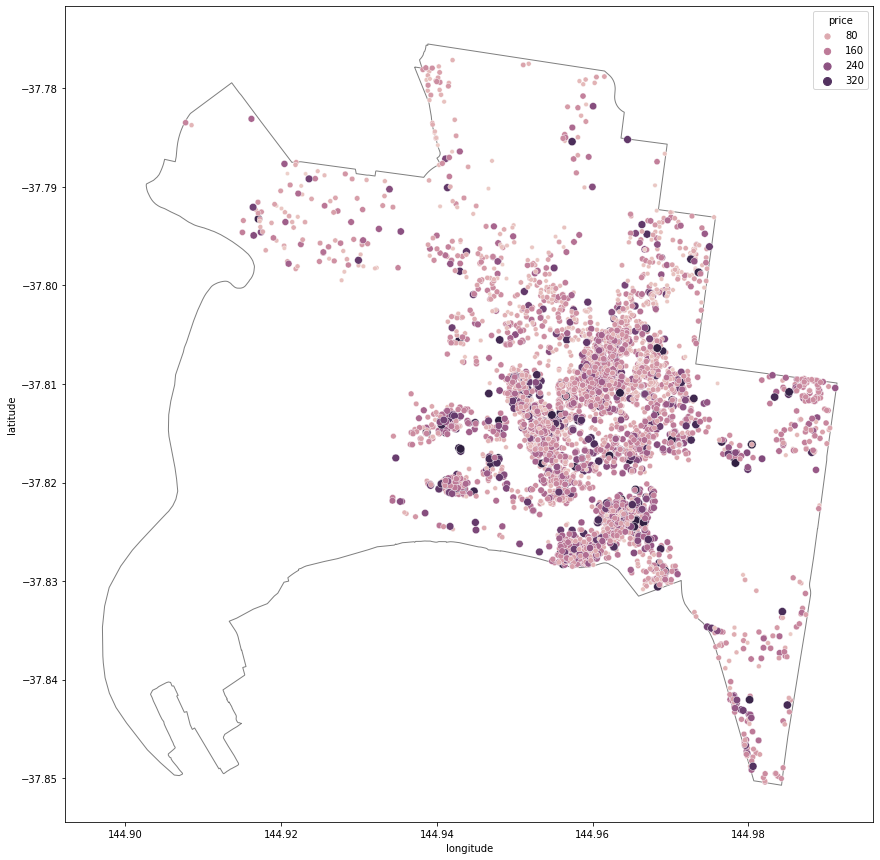

In [69]:
listings_melb_cbd = listings_melb_upt[(~is_outlier(listings_melb_upt['price'])) & (listings_melb_upt['neighbourhood_cleansed'] == 'Melbourne')]
wc_melb.plot(figsize=(25,15), color='white', edgecolor='gray')
sns.scatterplot(data=listings_melb_cbd, x='longitude', y='latitude', size='price', hue='price')

### How many listings are still active?

In [70]:
def get_day_month_year(df, date_col):
    tmp = pd.DataFrame(index=df.index)
    tmp['day'] = df[date_col].apply(lambda x: x.day)
    tmp['month'] = df[date_col].apply(lambda x: x.month)
    tmp['year'] = df[date_col].apply(lambda x: x.year)
    return tmp

In [71]:
calendar_melb_upt[['day','month','year']] = get_day_month_year(calendar_melb_upt, 'date')
calendar_melb_upt.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,day,month,year
0,438849,2021-12-08,False,200.0,200.0,10.0,1125.0,8,12,2021
1,9835,2021-12-08,True,60.0,60.0,1.0,365.0,8,12,2021
2,9835,2021-12-09,True,60.0,60.0,1.0,365.0,9,12,2021


In [72]:
# available indicates, about 6k of listings are no longer active
zero_availability = calendar_melb_upt.groupby('listing_id').sum()['available'] == 0

# match index in calendar_melb against index in listings_melb
zero_availability = pd.Series(zero_availability).sort_index()
zero_availability.index = listings_melb_upt.sort_values('id').index
zero_availability.value_counts()

False    11251
True      6583
Name: available, dtype: int64

In [73]:
# WHy does this differ with the `has_availability` 
listings_melb_upt['has_availability'].value_counts()

True     17664
False      170
Name: has_availability, dtype: int64

#### What influences price of stay?
**Data preprocessing and feature engineering**
- Let's further remove more columns before proceeding with our regression analysis
    - `id`
    - `name` - string data
    - `host_name` - string data
    - `description` - string data
    - `neighborhood_overview` - string data
    - `host_id`
    - `host_about` - string data
    - `host_neighbourhood` - string data with alot of missing values
    - `neighbourhood` - string data with missing values, of which completed data can be referenced from `neighbourhood_cleaned`
    - `latitude` and `longitude` - data is not linear against price
    - `property_type` - too high cardinality (high numebr of unique labels)
    - a number of `minimum` and `maximum` columns
    - `has_availability` and `instant_bookable` - this seems like data available as at that date
    - `availability_60` and `availability_90` since they are very correlated to `availability_30` 
    - `first_review` and `last_review`

- Possible to feature engineer 
    - `host_name`
    - `host_since`
    - `host_location` - local / foreigner
    
- Additional feature cleaning required as analyzed in our missing data analysis previously
    - `host_response_time`
    - `host_response_rate`
    - `host_acceptance_rate`

In [74]:
price_reg_filter = ['host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', \
                    'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', \
                    'neighbourhood_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', \
                    'availability_30', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', \
                    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', \
                    'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'bathrooms', 'bathroom_is_shared', \
                    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', \
                    'calculated_host_listings_count_shared_rooms'
                   ]

In [75]:
# Create new dataframe with filtered features
listings_melb_reg = listings_melb_upt[price_reg_filter]
listings_melb_reg.head(3)

,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bathrooms,bathroom_is_shared,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2009-08-21,AU,NaN,NaN,NaN,False,1.0,1.0,False,False,...,4.75,4.50,4.67,0.03,1.0,False,1,0,1,0
1,2009-10-31,"Melbourne, Victoria, Australia",NaN,NaN,NaN,False,13.0,13.0,True,True,...,4.83,4.78,4.66,0.30,1.0,False,10,10,0,0
2,2010-06-13,"Melbourne, Victoria, Australia",within an hour,0.9,0.96,True,1.0,1.0,True,True,...,4.00,5.00,4.00,0.02,2.5,False,1,0,1,0


**Revisitng missing values**
- Continuing from our analysis over missing values, let's try to understanding the following:
    1. How does number of reviews impact our number of missing values
    2. How does availability in next 365 days impact our missing values

It seems there are at least 23% of listings which have 0 reviews, and 34% of listings with 1 review or less
- Unsurprisingly, they contribute to a significant majority of missing values in the reviews features, e.g. `review_scores_checkin` etc of > `75%`
    - They also contribute to alot of missing values in our `host_acceptance_rate` and `host_response_rate` features of > 65%
- Let's remove listings with zero reviews and single reviews from our analysis with the assumption that single review listings tend to have a bias of review scores to that single review.
- Although not ideal, we set a minimum of 2 reviews required for our observations

In [76]:
# Listings with 0 reviews
(listings_melb_reg['number_of_reviews'] == 0).value_counts() / listings_melb_reg.shape[0]

False    0.763766
True     0.236234
Name: number_of_reviews, dtype: float64

In [77]:
# boolean index for listings with 1 review or less
review_morethan_1 = listings_melb_reg['number_of_reviews'] > 1
review_morethan_1.value_counts() / listings_melb_reg.shape[0]

True     0.657116
False    0.342884
Name: number_of_reviews, dtype: float64

In [78]:
# Missing data for listings with 1 review or less
data = listings_melb_reg[~review_morethan_1].isna().sum(axis=0).sort_values(ascending=False) / listings_melb_reg[~review_morethan_1].shape[0]
# only show missing vals > 10%
data[data > 0.10]

review_scores_checkin          0.744563
review_scores_location         0.744399
review_scores_value            0.744399
review_scores_accuracy         0.744072
review_scores_communication    0.743745
review_scores_cleanliness      0.743581
review_scores_rating           0.688962
reviews_per_month              0.688962
host_response_time             0.657073
host_response_rate             0.657073
host_acceptance_rate           0.641374
dtype: float64

In [79]:
# Removing 1 and less reviews from ur datset
listings_melb_reg = listings_melb_reg[review_morethan_1]
listings_melb_reg.shape

(11719, 37)

#### Price prediction - Feature engineering

In [80]:
# Inspection of string and datetime features
listings_melb_reg.select_dtypes(include=['object', 'datetime']).head(5)

,host_since,host_location,host_response_time,neighbourhood_cleansed,room_type
0,2009-08-21,AU,NaN,Manningham,Private room
1,2009-10-31,"Melbourne, Victoria, Australia",NaN,Port Phillip,Entire home/apt
2,2010-06-13,"Melbourne, Victoria, Australia",within an hour,Melbourne,Private room
3,2010-07-12,"Berwick, Victoria, Australia",within an hour,Casey,Entire home/apt
4,2010-07-27,"Melbourne, Victoria, Australia",NaN,Darebin,Private room


**Location of host**

In [81]:
# Foreign locations, 
# There are 20 n/a values, we default these to not local, i.e. False
def get_local(df):
    return (df['host_location'].str.contains(r'\b[Aa]ustralia\b')) \
            | (df['host_location'].str.contains(r'\b[Aa][Uu]\b')) \
            | (df['host_location'].str.contains(r'\b[Mm]elbourne\b')) \
            | (df['host_location'].str.contains(r'\b[Cc][Xx]\b')) \
            | (df['host_location'].str.contains(r'\b[Cc]hristmas [Ii]sland\b')) \
            | (df['host_location'].str.contains(r'\b[Nn]ew [Zz]ealand\b')) \
            | (df['host_location'].isna())

Our filtered dataset shows that there are 96% of local hosts compared to 3.7% of foreign hosts

In [82]:
# Proportion of locals vs foreigners
get_local(listings_melb_reg).value_counts() / listings_melb_reg.shape[0]

True     0.96271
False    0.03729
Name: host_location, dtype: float64

**Host since**

- Majority of our hosts commenced renting out their Airbnb in 2015/2016
- The proportion of new hosts in the past couple of years (2020/2021) is very minimal, accounting for 4% and 2% respectively. This is unsurprising due to the covid 19 pandemic

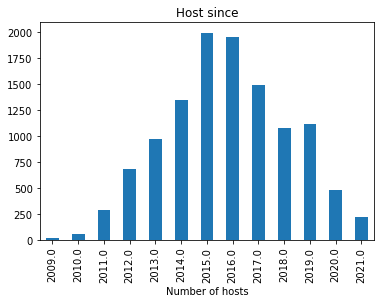

2009.0    0.001365
2010.0    0.005120
2011.0    0.024917
2012.0    0.058025
2013.0    0.083028
2014.0    0.115027
2015.0    0.170322
2016.0    0.166823
2017.0    0.127485
2018.0    0.092073
2019.0    0.095742
2020.0    0.041215
2021.0    0.018602
Name: host_since, dtype: float64

In [83]:
host_since = listings_melb_reg['host_since'].apply(lambda x : x.year).value_counts().sort_index()
plt.title('Host since')
plt.xlabel('Number of hosts')
host_since.plot.bar()
plt.show()
host_since / listings_melb_reg.shape[0]

**One hot encode `host_response_time` and `neighbourhood_cleansed`**
- There doesn't seem to be missing values for neighbourhood_cleansed, so let's just one hot encode this column as is
- There are alot of NaN values for `host_response_time`, since there are many, let's consider these NaN values as its own separate category rather than imputing these values

In [84]:
listings_melb_reg['host_response_time'].value_counts(dropna=False)

NaN                   5114
within an hour        4781
within a few hours    1026
within a day           576
a few days or more     222
Name: host_response_time, dtype: int64

In [85]:
listings_melb_reg['neighbourhood_cleansed'].value_counts(dropna=False)

Melbourne            3628
Port Phillip         1359
Yarra                 973
Stonnington           794
Yarra Ranges          686
Moreland              474
Darebin               335
Monash                307
Boroondara            290
Whitehorse            283
Glen Eira             276
Maribyrnong           257
Wyndham               245
Bayside               197
Moonee Valley         182
Manningham            149
Kingston              149
Hobsons Bay           128
Banyule               127
Frankston             120
Cardinia              107
Casey                  97
Knox                   97
Hume                   90
Brimbank               76
Whittlesea             64
Greater Dandenong      62
Nillumbik              59
Maroondah              59
Melton                 49
Name: neighbourhood_cleansed, dtype: int64

**Amenities and verifications**
- As we've stored these array values separately, let's attempt to feature engineer by summing up total amenities and verifications for each listing
- These 2 features seem to have a decent distribution

<AxesSubplot:>

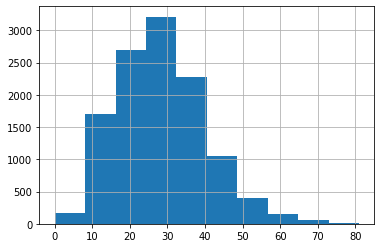

In [86]:
# Amenities spread
amenities[review_morethan_1].sum(axis=1).hist()

<AxesSubplot:>

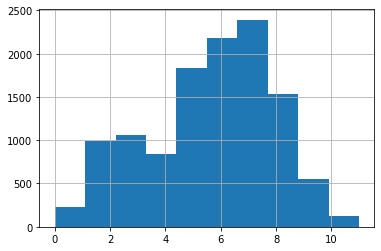

In [87]:
# Verifications spread
verifications[review_morethan_1].sum(axis=1).hist()

**Categorical pipeline**

In [88]:
def categorical_feature_eng(df):
    tmp = df.copy()
    # get local
    tmp['is_local'] = get_local(tmp)
    # get host since
    tmp['host_since_year'] = tmp['host_since'].apply(lambda x : x.year)
    # one hot encode neighbourhood_cleansed and host_response_time
    tmp = pd.concat([tmp, pd.get_dummies(tmp['host_response_time'], prefix='response_time', prefix_sep='_', dummy_na=True)], axis=1)
    tmp = pd.concat([tmp, pd.get_dummies(tmp['neighbourhood_cleansed'], prefix='neighbourhood', prefix_sep='_')], axis=1)
    tmp = pd.concat([tmp, pd.get_dummies(tmp['room_type'], prefix='room_type', prefix_sep='_')], axis=1)
    # counts
    tmp['amenities_num'] = amenities.sum(axis=1)
    tmp['verifications_num'] = verifications.sum(axis=1)
    # drop cols
    tmp.drop(['is_local', 'host_since', 'host_response_time', 'neighbourhood_cleansed', 'host_location', 'room_type'], axis=1, inplace=True)
    return tmp

**Numerical Features**

In [89]:
listings_melb_reg.select_dtypes(exclude='object').isna().sum(axis=0).sort_values(ascending=False)[:15]

host_response_rate             5114
host_acceptance_rate           4513
bedrooms                        491
beds                            335
review_scores_location           38
review_scores_value              38
review_scores_checkin            37
review_scores_accuracy           36
review_scores_communication      36
review_scores_cleanliness        36
bathrooms                        14
host_total_listings_count         3
host_listings_count               3
host_since                        3
bathroom_is_shared                0
dtype: int64

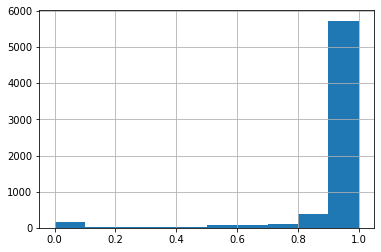

<AxesSubplot:>

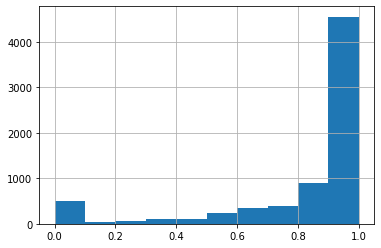

In [90]:
# Analyzing host_response_rate and acceptance rate
listings_melb_reg['host_response_rate'].hist()
plt.show()
listings_melb_reg['host_acceptance_rate'].hist()

In [91]:
# Mean
print(listings_melb_reg['host_response_rate'].mean())
print(listings_melb_reg['host_acceptance_rate'].mean())

0.9399802088737488
0.8227540850639343


In [92]:
# Imputing mean values
def numerical_preprocess(df):
    numerical_cols = df.select_dtypes(exclude='object').columns
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].mean())
    return df

#### Predicting price

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import r2_score

In [94]:
# Removing outliers
reg_data = categorical_feature_eng(listings_melb_reg)
reg_data.drop(['host_acceptance_rate', 'host_response_rate'], axis=1, inplace=True)
reg_data = numerical_preprocess(reg_data)

In [95]:
# Removing outliers
reg_data = reg_data[(~is_outlier(reg_data['price']))]

# Splitting features and predictor
X = reg_data.drop('price', axis=1)
y = reg_data['price']
y_norm = (y-min(y))/(max(y)-min(y))

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.25, random_state=42)
print(f'Size of train - {X_train.shape[0]}')
print(f'Size of test - {X_test.shape[0]}' )

Size of train - 8151
Size of test - 2717


In [96]:
# Reference for ridge regression - https://www.kaggle.com/krystal96/ridge-regression
# Cross-validation test
alphas = 10**np.linspace(-3,3,100)
ridge_cv = RidgeCV(alphas = alphas, normalize=True, cv = 10,scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)
# best lambda
ridge_cv.alpha_

0.0030538555088334154

In [97]:
model_ridge=Ridge(alpha = ridge_cv.alpha_)
model_ridge.fit(X_train,y_train)
pred_ridge= model_ridge.predict(X_test)

# evaluate the result
rmse = np.sqrt(metrics.mean_squared_error(y_test,pred_ridge))
r_square = metrics.r2_score(y_test, pred_ridge)
print('For test data set our final result is:')
print('RMSE {}'.format(rmse ))
print('R^2 is {}'.format(r_square))

For test data set our final result is:
RMSE 0.14352937068738236
R^2 is 0.5614073802163122


In [98]:
coefficients = pd.DataFrame(data={'feature_name':X_train.columns, 'coef': model_ridge.coef_})
coefficients['abs'] = coefficients['coef'].abs()

In [99]:
coefficients.sort_values('abs', ascending=False)[:20]

,feature_name,coef,abs
64,neighbourhood_Yarra Ranges,0.200959,0.200959
66,room_type_Hotel room,0.150048,0.150048
68,room_type_Shared room,-0.109985,0.109985
39,neighbourhood_Cardinia,0.088623,0.088623
67,room_type_Private room,-0.082725,0.082725
38,neighbourhood_Brimbank,-0.082151,0.082151
61,neighbourhood_Whittlesea,-0.077983,0.077983
62,neighbourhood_Wyndham,-0.073945,0.073945
57,neighbourhood_Nillumbik,0.073125,0.073125
21,review_scores_value,-0.068912,0.068912


In [100]:
sns.set_theme(style="whitegrid")

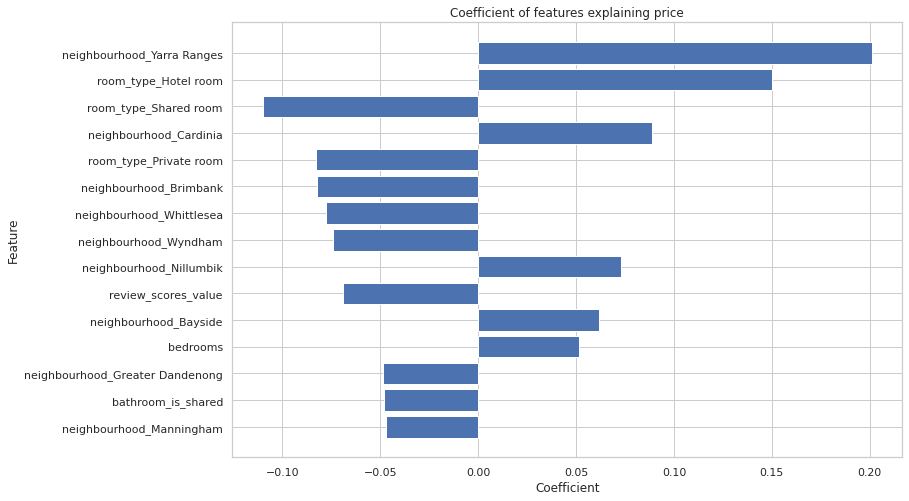

In [101]:
plt.figure(figsize=(12,8))
sorted_coefficients = coefficients.sort_values('abs', ascending=False)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficient of features explaining price')
plt.barh(sorted_coefficients['feature_name'][:15], sorted_coefficients['coef'][:15])
plt.gca().invert_yaxis()

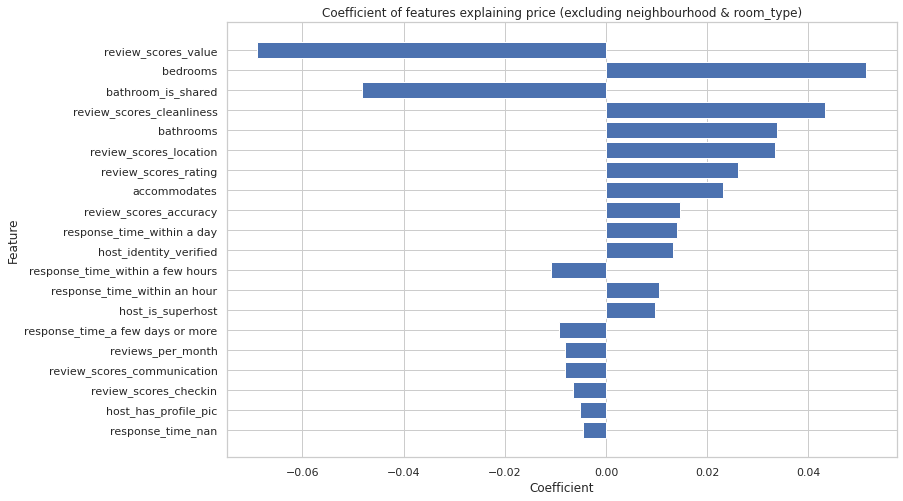

In [102]:
# Excluding neighborhood coefficients
# Split this to observable and qualitative aspects driving price
plt.figure(figsize=(12,8))
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficient of features explaining price (excluding neighbourhood & room_type)')
is_neighbourhood = sorted_coefficients['feature_name'].str.contains('neighbourhood_')
is_roomtype = sorted_coefficients['feature_name'].str.contains('room_type_')
plt.barh(sorted_coefficients.loc[(~is_neighbourhood) & (~is_roomtype), 'feature_name'][:20], sorted_coefficients.loc[(~is_neighbourhood) & (~is_roomtype), 'coef'][:20])
plt.gca().invert_yaxis()

**Reviews YoY/ MoM/ DoD**

In [103]:
reviews_melb_upt[['day', 'month', 'year']] = get_day_month_year(reviews_melb_upt, 'date')

In [104]:
reviews_melb_upt

,listing_id,id,date,reviewer_id,reviewer_name,comments,day,month,year
0,9835,279854,2011-05-24,560832,Miriam,"Very hospitable, much appreciated.\r<br/>",24,5,2011
1,9835,3640746,2013-02-26,5143343,Michelle,A beautiful house in a lovely quiet neighbourh...,26,2,2013
2,9835,23731188,2014-12-08,2478713,Karyn,This was my first time using airbnb and it was...,8,12,2014
3,9835,46588875,2015-09-12,26184717,Rosalind,I was visiting Melbourne to spend time with my...,12,9,2015
4,12936,73473,2010-08-04,111479,Brian,Perfect apartment in a perfect location!!!! \r...,4,8,2010
...,...,...,...,...,...,...,...,...,...
466954,53612627,510312807033344053,2021-12-04,342999888,Mudathir,- Excellent communications <br/>- I was given ...,4,12,2021
466955,53612891,511055293416309980,2021-12-05,158795693,Ashleigh,"Accomodation was clean, in a good location and...",5,12,2021
466956,53613335,511090334149813479,2021-12-05,312130611,Joshua,one of the best views we've had in the city. w...,5,12,2021
466957,53645767,510334058295687329,2021-12-04,230724494,Chanchal,I booked Hisham's place at last moment at nigh...,4,12,2021


<AxesSubplot:xlabel='year'>

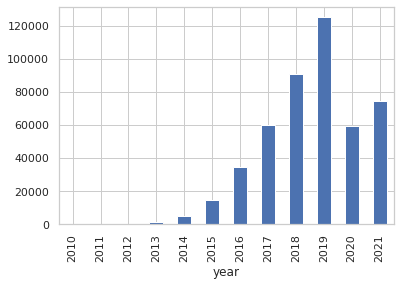

In [105]:
# Year on year
yoy = reviews_melb_upt.groupby('year').count()['id']
yoy.plot.bar()

In [106]:
yoy_hostsince = pd.DataFrame(index = yoy.index, data={'reviews': yoy})
yoy_hostsince['hostsince'] = listings_melb_reg['host_since'].apply(lambda x : x.year).value_counts()
yoy_hostsince

,reviews,hostsince
year,,
2010,6,60
2011,145,292
2012,522,680
2013,1542,973
2014,5068,1348
2015,14887,1996
2016,34438,1955
2017,60296,1494
2018,91002,1079


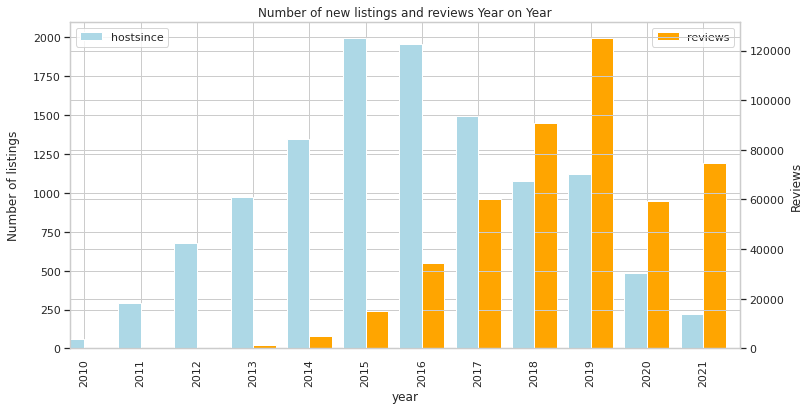

In [107]:
# https://stackoverflow.com/questions/24183101/pandas-bar-plot-with-two-bars-and-two-y-axis
fig = plt.figure(figsize=(12,6)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

yoy_hostsince.hostsince.plot(kind='bar', color='lightblue', ax=ax2, width=width, position=1)
yoy_hostsince.reviews.plot(kind='bar', color='orange', ax=ax, width=width, position=0)

# https://stackoverflow.com/questions/10354397/python-matplotlib-y-axis-ticks-on-right-side-of-plot
ax.yaxis.tick_right()
ax.set_ylabel('Number of listings')
ax.yaxis.labelpad = 50 # Adjust x-axis label position
ax2.yaxis.tick_left()
ax2.set_ylabel('Reviews')
ax2.yaxis.labelpad = 50 # Adjust x-axis label position
ax.legend()
plt.legend(loc='upper left')
plt.title('Number of new listings and reviews Year on Year')
plt.show()

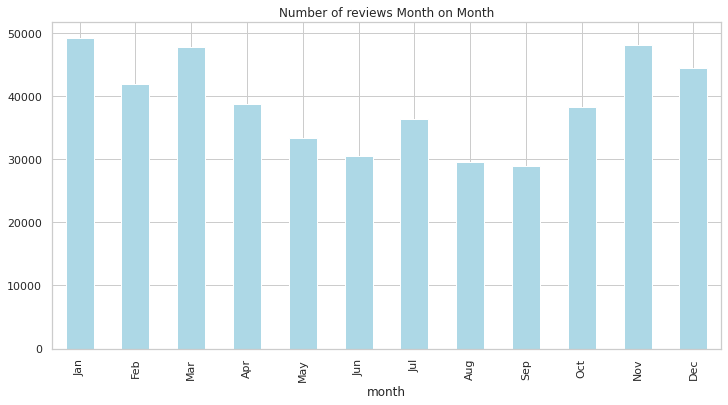

In [108]:
# Month on month
plt.figure(figsize=(12,6))
plt.title('Number of reviews Month on Month')
reviews_melb_upt.groupby('month').count()['id'].plot.bar(color='lightblue')
plt.xticks(list(range(0,12)), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=90)

plt.show()

<AxesSubplot:xlabel='day'>

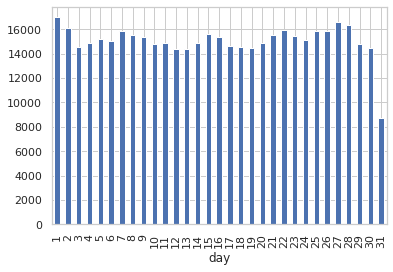

In [109]:
# Day on Day
reviews_melb_upt.groupby('day').count()['id'].plot.bar()